# Identify AR Events Gridded

In [152]:
%matplotlib ipympl

In [153]:
import ARUtils
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

Load data from 1980 - 1989

In [154]:
ds_full = xr.open_dataset('b.e21.BHISTsmbb.f09_g17.LE2-1111.006.cam.h2.IVT.1980010100-1989123100.nc')

Select a set of grid cell that cover Bodega Bay, CA (38.3332° N, 123.0481° W)

In [155]:
lat = 38.
lon = -123.125 + 360 
AR_THRESHOLD = 250.

# the nearest index for the lat/lon provided above
ilon = list(ds_full.lon.values).index(ds_full.sel(lon=lon, method='nearest').lon)
ilat = list(ds_full.lat.values).index(ds_full.sel(lat=lat, method='nearest').lat)

# subset these data to include cells above and below this lat/lon
cell_buffer = 5
ds = ds_full.isel(lat=range(ilat-cell_buffer, ilat+cell_buffer),
                  lon=range(ilon-cell_buffer, ilon+cell_buffer)).IVT

Plot the IVT data for these cells (cumulative). This has no quantitive meaning, it only serves the purpose of visualizing our domain.

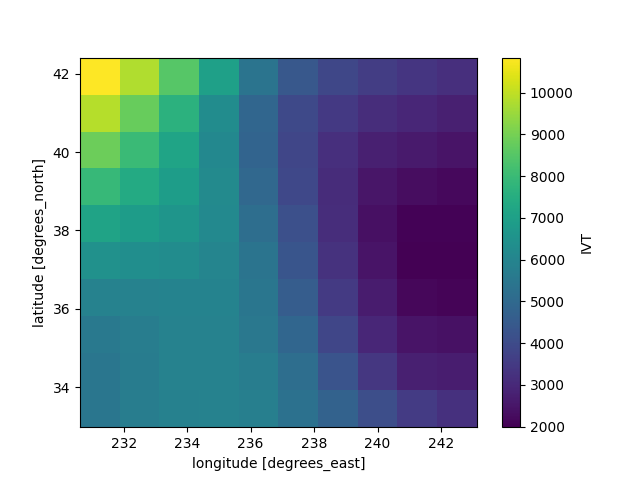

In [156]:
# plot a small time span of these data so we can visualize the domain
fig, ax = plt.subplots()
ds.sel(time=slice('1980-01-01', '1980-01-10')).sum(dim='time').plot();

In [157]:
ds = ds.to_dataset()
ds

<xarray.Dataset> Size: 6MB
Dimensions:  (lat: 10, lon: 10, time: 14600)
Coordinates:
  * lat      (lat) float64 80B 33.46 34.4 35.34 36.28 ... 40.05 40.99 41.94
  * lon      (lon) float64 80B 231.2 232.5 233.8 235.0 ... 240.0 241.2 242.5
  * time     (time) object 117kB 1980-01-01 00:00:00 ... 1989-12-31 18:00:00
Data variables:
    IVT      (time, lat, lon) float32 6MB ...

In [158]:

def identify_ar_events(da):
    AR_THRESHOLD = 250
    
    # isolate the days in which the minimum AR conditions are met.
    ds_thr = xr.where((da >= AR_THRESHOLD), 1, 0)
    
    # Flatten the array
    flattened = ds_thr
    flattened = np.insert(flattened, 0, 0, axis=0)
    flattened = np.append(flattened, 0)

    ar_events = np.zeros(flattened.shape)
    
    # Initialize variables
    event = 0

    # Initialize variables
    current_sequence = 0
    for idx in range(1, len(flattened)):

        # we hit a value of 1
        if flattened[idx] == 1:
            if flattened[idx - 1] == 0:
                # this is the first value in the set
                event += 1
            ar_events[idx] = event

    # return all but the first zero that we added
    return ar_events[1:-1]#.reshape(da.shape)



def compute_ar_durations(arr):
    """
    arr: DataArray of AR_INDEX
    """

    # Create an empty list to store the result
    result = []

    # Initialize variables to keep track of the current sequence
    current_value = arr[0]
    count = 1

    # Iterate over the array starting from the second element
    for i in range(1, len(arr)):
            
        if arr[i] == arr[i - 1]:  # Check if the current value is identical to the previous one
            # If the current number is identical, increment the count
            count += 1
        else:
            # skip values that equal zero
            if current_value == 0:
                result.extend([0] * count)
            else:
                # If the current number is not identical, append the count to the result list
                result.extend([count] * count)
            
            # Reset the current value and count
            current_value = arr[i]
            count = 1

    # Append the count for the last group of identical integers
    if current_value == 0:
        result.extend([0] * count)
    else:
        result.extend([count] * count)

    return np.array(result)


def compute_ar_category(ar_index, ar_duration, ar_ivt):

    # Initialize AR Category lookup table
    AR = np.zeros((200, 300)) + 5
    # cat 4
    AR[125:150, :24] = 4
    AR[100:125, 24:48] = 4
    AR[75:100, 48:72] = 4
    AR[50:75, 72:96] = 4
    AR[25:50, 96:120] = 4
    # cat 3
    AR[100:125, :24] = 3
    AR[75:100, 24:48] = 3
    AR[50:75, 48:72] = 3
    AR[25:50, 72:96] = 3
    # cat 2
    AR[75:100, :24] = 2
    AR[50:75, 24:48] = 2
    AR[25:50, 48:72] = 2
    # cat 1
    AR[50:75, :24] = 1
    AR[25:50, 24:48] = 1
    # cat 0
    AR[:25, :] = 0
    AR[25:50, :24] = 0

    # initialize array to store category information
    cat = np.zeros(len(ar_index))

    # Initialize variables to keep track of the current sequence
    last_idx = 0
    max_ivt = 0
    duration = 0
    start_i = 0
    
    # compute AR Category by combining max_ivt and AR duration.
    # Iterate over the array starting from the second element
    for i in range(0, len(ar_index)):
        idx = ar_index[i]

        # condition 1: zero
        if idx == 0:
            if max_ivt > 0:
                cat[start_i:i] = AR[int(round(max_ivt / 10, 0)), int(duration * 6)]
                max_ivt = 0
                duration = 0

        # condition 2: current index is not zero and last index is zero
        elif idx > 0 and last_idx == 0:
            start_i = i
            duration = ar_duration[i]
                
        # condition 3: current index == last index
        elif idx == last_idx:
            # save the ivt if it's greater than max_ivt
            if ar_ivt[i] > max_ivt:
                max_ivt = ar_ivt[i]
        
        # save this index and move onto the next, i.e. ignore zeros.
        last_idx = idx
        
    return cat

In [160]:
# res = identify_ar_events(ds.isel(lat=5, lon=9).IVT)
# fig, ax = plt.subplots()
# ax.plot(res)

res = xr.apply_ufunc(
    identify_ar_events,  
    ds.IVT,  
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True
)

ds['AR_INDEX'] = res

In [161]:
# res = compute_ar_durations(ds.isel(lat=5, lon=9).AR_INDEX)
# fig, ax = plt.subplots()
# ax.plot(res)

res = xr.apply_ufunc(
    compute_ar_durations,  
    ds.AR_INDEX,  
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True
)

ds['AR_DURATION'] = res


In [162]:
# res = compute_ar_category(ds.isel(lat=5, lon=9).AR_INDEX,ds.isel(lat=5, lon=9).AR_DURATION,ds.isel(lat=5, lon=9).IVT)
# fig, ax = plt.subplots()
# ax.plot(res)

res = xr.apply_ufunc(
    compute_ar_category,  
    ds.AR_INDEX,
    ds.AR_DURATION,
    ds.IVT,
    input_core_dims=[["time"],["time"],["time"]],
    output_core_dims=[["time"]],
    vectorize=True
)

ds['AR_CATEGORY'] = res

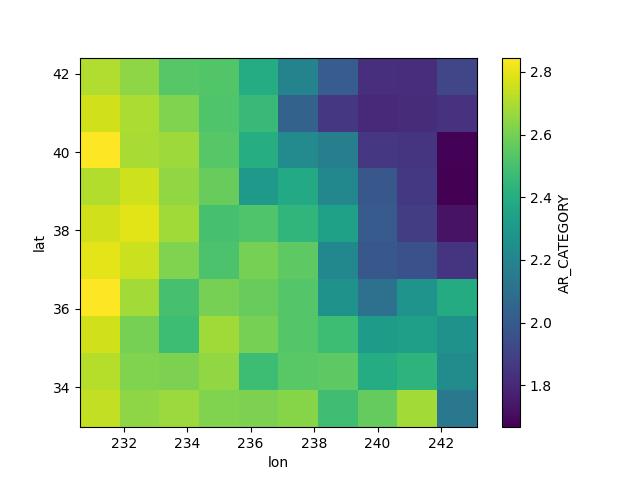

In [163]:
ds.where(ds.AR_CATEGORY > 0).AR_CATEGORY.mean(dim='time').plot()
plt.show()

## Validation

Look at the results for a single cell to see if they match what we computed in the non-gridded functions. Compare with the plots created in `Identify_AR_Events.ipynb`.

In [172]:
ds_cell = ds.sel(lat=lat, lon=lon, method='nearest')
ds_cell

<xarray.Dataset> Size: 526kB
Dimensions:      (time: 14600)
Coordinates:
    lat          float64 8B 38.17
    lon          float64 8B 237.5
  * time         (time) object 117kB 1980-01-01 00:00:00 ... 1989-12-31 18:00:00
Data variables:
    IVT          (time) float32 58kB 130.7 133.5 154.3 ... 67.99 84.58 108.8
    AR_INDEX     (time) float64 117kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    AR_DURATION  (time) int64 117kB 0 0 0 0 0 1 0 0 0 0 ... 4 0 0 0 0 0 0 0 0 0
    AR_CATEGORY  (time) float64 117kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

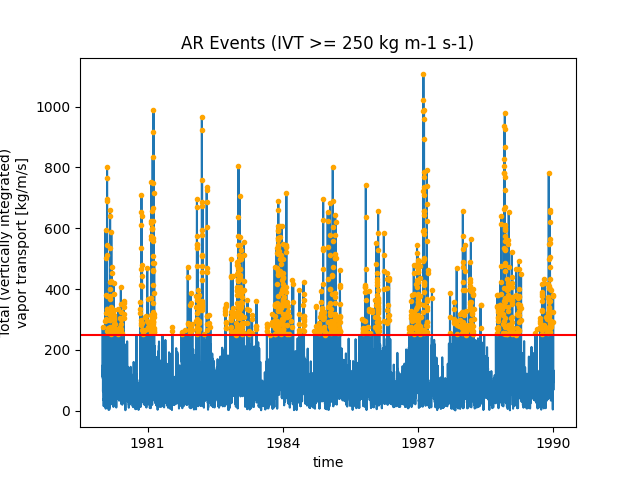

In [173]:
fig, ax = plt.subplots()
ds_cell.IVT.plot()
ds_cell.where((ds_cell >= AR_THRESHOLD)).IVT.plot(linestyle='', marker='.', color='orange')
ax.axhline(y=AR_THRESHOLD, color='red')
plt.title('AR Events (IVT >= 250 kg m-1 s-1)')
plt.show()

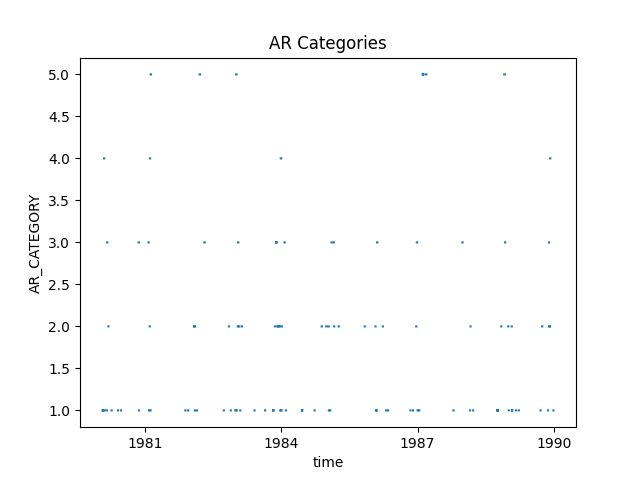

In [174]:
# plot AR Categories
fig, ax = plt.subplots()
ds_cell.where(ds_cell.AR_CATEGORY > 0).AR_CATEGORY.plot()
plt.title('AR Categories');

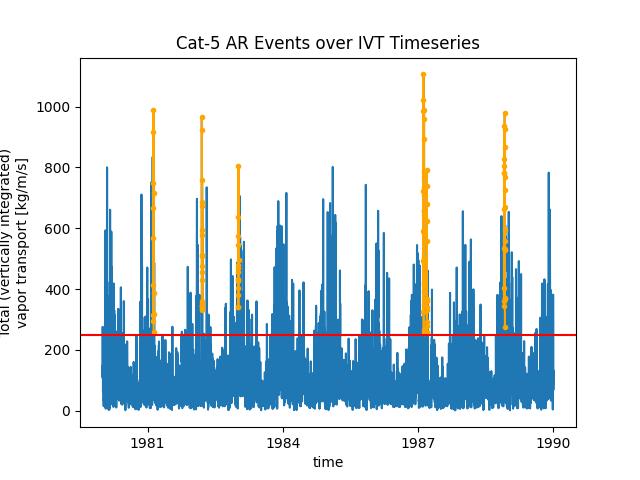

In [175]:
fig, ax = plt.subplots()
ds_cell.IVT.plot()

dat5 = ds_cell.where(ds_cell.AR_CATEGORY == 5, drop=True)
for idx, dd in dat5.groupby(dat5.AR_INDEX):
        vals = dd.IVT.values
        if len(vals) > 1:
            dd.IVT.plot(linestyle='-', marker='.', color='orange')

ax.axhline(y=AR_THRESHOLD, color='red')
plt.title('Cat-5 AR Events over IVT Timeseries')
plt.show()